# Analyse d'Impact Écologique

Ce notebook fonctionne à la fois localement et sur Google Colab.

In [1]:
def setup_environment():
    import sys
    from pathlib import Path
    
    # Détecter si on est sur Colab
    try:
        import google.colab
        print("Environnement Colab détecté, configuration...")
        !git clone git@github.com:fabricehong/eco-certificates.git
        %cd eco-certificates
    except ImportError:
        print("Environnement local détecté, configuration...")
        # En local, on ajoute juste le répertoire parent au PYTHONPATH
        project_root = Path().absolute().parent
        if str(project_root) not in sys.path:
            sys.path.append(str(project_root))

setup_environment()

Environnement local détecté, configuration...


In [2]:
# Importer notre classe depuis le module
from src.models.eco_calculator import EcoCalculator

# Créer une instance
calculator = EcoCalculator(base_impact=1.0)

In [3]:
# Charger et analyser les données
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données depuis notre CSV
from pathlib import Path
project_root = Path().absolute().parent
df = pd.read_csv(project_root / 'data' / 'sample_devices.csv')

# Calculer l'impact pour chaque appareil
df['impact'] = df.apply(lambda row: calculator.calculate_impact(
    row['usage_hours'], 
    row['energy_efficiency']
), axis=1)

# Ajouter la notation écologique
df['eco_rating'] = df['impact'].apply(calculator.get_eco_rating)

# Afficher les résultats
print("Résultats de l'analyse d'impact écologique :")
print(df)

Résultats de l'analyse d'impact écologique :
  device_name  usage_hours  energy_efficiency     impact eco_rating
0      Laptop            8               0.85   9.411765          F
1  Desktop PC            6               0.70   8.571429          F
2      Server           24               0.90  26.666667          F
3  Smartphone            4               0.95   4.210526          E
4      Tablet            3               0.90   3.333333          D


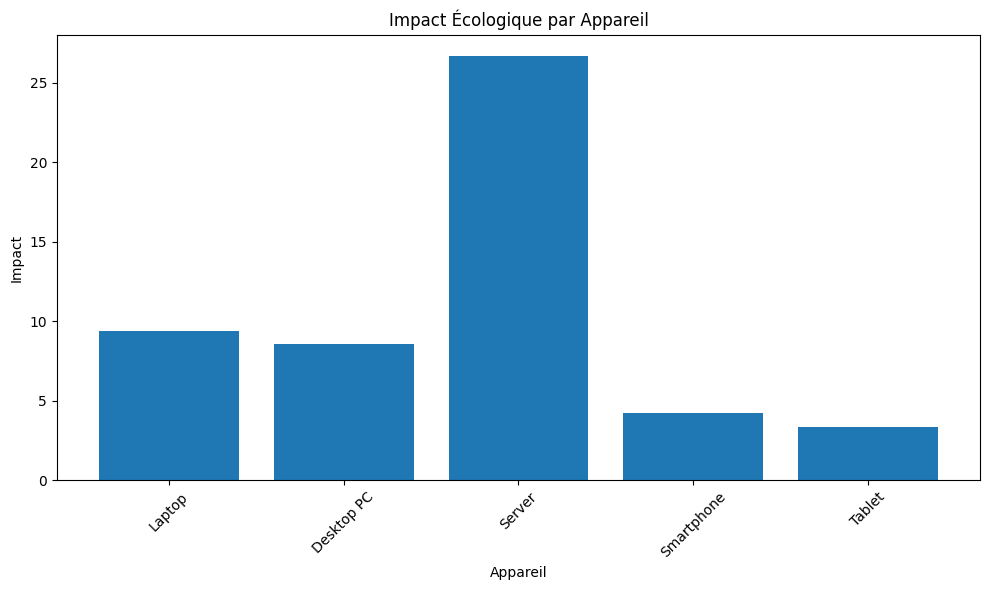

In [4]:
# Créer un graphique
plt.figure(figsize=(10, 6))
plt.bar(df['device_name'], df['impact'])
plt.title('Impact Écologique par Appareil')
plt.xlabel('Appareil')
plt.ylabel('Impact')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()